# Using `partial_fit()` with grid search
`GridSearchCV` doesn't have a `partial_fit()` method, but we can use `GridSearchCV` to find the best initial hyperparameters for our models before moving to `partial_fit()`.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sqlite3

with sqlite3.connect('../../ch_11/logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        'SELECT * FROM logs WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
    hackers_2018 = pd.read_sql(
        'SELECT * FROM attacks WHERE start BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['start', 'end']
    ).assign(
        duration=lambda x: x.end - x.start, 
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )

## Get training and testing sets

In [2]:
def get_X(log, day):
    """
    Get data we can use for the X
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
    
    Returns: 
        A pandas DataFrame
    """
    return pd.get_dummies(log[day].assign(
        failures=lambda x: 1 - x.success
    ).query('failures > 0').resample('1min').agg(
        {'username':'nunique', 'failures': 'sum'}
    ).dropna().rename(
        columns={'username':'usernames_with_failures'}
    ).assign(
        day_of_week=lambda x: x.index.dayofweek, 
        hour=lambda x: x.index.hour
    ).drop(columns=['failures']), columns=['day_of_week', 'hour'])

def get_y(datetimes, hackers, resolution='1min'):
    """
    Get data we can use for the y (whether or not a hacker attempted a log in during that time).
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        A pandas Series of booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series()
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

def get_X_y(log, day, hackers):
    """
    Get the X, y data to build a model with.
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
        - hackers: The dataframe indicating when the attacks started and stopped
        
    Returns:
        X, y tuple where X is a pandas DataFrame and y is a pandas Series
    """
    X = get_X(log, day)
    y = get_y(X.reset_index().datetime, hackers)
    return X, y

In [3]:
X_jan, y_jan = get_X_y(logs_2018, '2018-01', hackers_2018)
X_feb, y_feb = get_X_y(logs_2018, '2018-02', hackers_2018)

## Step 1: Run GridSearchCV to build a Passive Aggressive Classifier
Train on January 2018.

In [4]:
%%capture
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from ml_utils.partial_fit_pipeline import PartialFitPipeline

pipeline = PartialFitPipeline([
    ('scale', StandardScaler()), 
    ('pa', PassiveAggressiveClassifier(random_state=0, max_iter=1000, tol=1e-3))
])

search_space = {
    'pa__C' : [0.01, 0.1, 1, 10],
    'pa__fit_intercept' : [True, False],
    'pa__class_weight' : ['balanced', None]
}

pa_grid = GridSearchCV(pipeline, search_space, cv=5, scoring='f1_macro').fit(X_jan, y_jan)

In [5]:
pa_grid.best_params_

{'pa__C': 0.1, 'pa__class_weight': None, 'pa__fit_intercept': True}

### Evaluate the model's initial performance (on February)

In [6]:
preds = pa_grid.predict(X_feb)
pd.Series(preds).value_counts()

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


False    37790
True        13
dtype: int64

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_feb, preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     37787
        True       0.92      0.75      0.83        16

   micro avg       1.00      1.00      1.00     37803
   macro avg       0.96      0.87      0.91     37803
weighted avg       1.00      1.00      1.00     37803



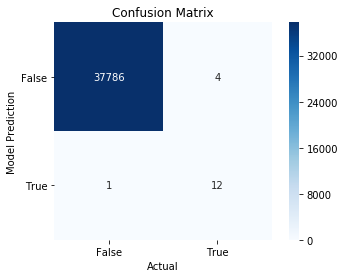

In [8]:
from ml_utils.classification import confusion_matrix_visual

confusion_matrix_visual(y_feb, preds, class_labels=[False, True])

## Step 2: Store the best estimator for `partial_fit()` usage later

In [9]:
pa = pa_grid.best_estimator_

## Step 3: Update the model with the February 2018 data

In [10]:
pa.partial_fit(X_feb, y_feb)

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PartialFitPipeline(memory=None,
          steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pa', PassiveAggressiveClassifier(C=0.1, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=1000, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False))])

## Step 4: Evaluate model on March through June 2018 data

In [11]:
X_mar, y_mar = get_X_y(logs_2018, '2018-03', hackers_2018)
X_q2, y_q2 = get_X_y(logs_2018, '2018-Q2', hackers_2018)
X_eval = pd.concat([X_mar, X_q2])
y_eval = pd.concat([y_mar, y_q2])
preds = pa.predict(X_eval)

c:\users\molinstefanie\packt\venv\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_eval, preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    168783
        True       1.00      0.83      0.91        12

   micro avg       1.00      1.00      1.00    168795
   macro avg       1.00      0.92      0.95    168795
weighted avg       1.00      1.00      1.00    168795



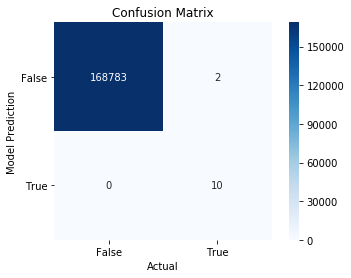

In [13]:
from ml_utils.classification import confusion_matrix_visual

confusion_matrix_visual(y_eval, preds, class_labels=[False, True])